In [533]:
import numpy as np
import pandas as pd
import patsy as pt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn import metrics
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn import model_selection

from IPython.display import HTML
from ipywidgets import interact
import ipywidgets as widgets
import copy
import warnings
warnings.filterwarnings('ignore')

## 6. In this exercise, you will further analyze the Wage data set considered throughout this chapter

**(a) Perform polynomial regression to predict wage using age. Use cross-validation to select the optimal degree d for the polynomial. What degree was chosen, and how does this compare to the results of hypothesis testing using ANOVA? Make a plot of the resulting polynomial fit to the data**

In [4]:
url = 'https://raw.githubusercontent.com/JWarmenhoven/ISLR-python/master/Notebooks/Data/Wage.csv'
wage = pd.read_csv(url, error_bad_lines=False)
#wage = wage.drop(wage['Unnamed: 0'],axis=1)
wage.head()

,Unnamed: 0,year,age,sex,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,231655,2006,18,1. Male,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,86582,2004,24,1. Male,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,161300,2003,45,1. Male,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,155159,2003,43,1. Male,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,11443,2005,50,1. Male,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


In [37]:
wage_df = wage

In [38]:
wage_df.head()

,year,age,sex,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Male,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Male,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,1. Male,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,1. Male,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,1. Male,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


In [428]:
def ols_cv(formula, X, y, k):
    """Perform k-fold cross validation to return mean MSE score
    Expects formula as Patsy formula"""
    # Split dataset into k-folds
    # Note: np.array_split doesn't raise excpetion is folds are unequal in size
    X_folds = np.array(np.array_split(X, k))
    y_folds = np.array(np.array_split(y, k))
    
    RMSEs = []
    for f in np.arange(len(X_folds)):
        # Create training and test sets
        X_test  = X_folds[f]
        y_test  = y_folds[f]
        X_train = np.delete(X_folds, f, 0).reshape(-1, X_folds.shape[-1])
        y_train = np.delete(y_folds, f, 0).reshape(-1, 1)
        # Fit model
        model = sm.OLS(y_train, X_train).fit()
        # Measure MSE
        y_hat = model.predict(X_test)
        RMSEs += [np.sqrt(metrics.mean_squared_error(y_test, y_hat))]
    return np.mean(RMSEs)


        
def polynomial_regression(X,y):
    results = []
    for p in np.arange(1,15):
        formula = ' + '.join(['np.power(age,{})'.format(i) for i in np.arange(1,p+1)])
        X_matrix = pt.dmatrix(formula,X)
        y = np.asarray(y)
        results += [(ols_cv(formula,X_matrix,y,10),p)]
        
    print(results)
        
    df = pd.DataFrame({'RMSE': [r[0] for r in results],
                      'Degree': [r[1] for r in results]})
    
    plt.figure(figsize=(8,8))
    sns.lineplot(x='Degree',y='RMSE',data = df)
    
    display(df[df['RMSE']==df['RMSE'].min()])
        
    

[(40.84406227564555, 1), (39.927962370328046, 2), (39.8629627468185, 3), (39.84520702162396, 4), (39.85301824470161, 5), (39.84718049506201, 6), (39.84934872142453, 7), (39.85782923540088, 8), (39.86725867923501, 9), (39.929281575964055, 10), (39.93857337313564, 11), (40.10033811451849, 12), (41.00470071250621, 13), (41.036779791806296, 14)]


,RMSE,Degree
3,39.845207,4


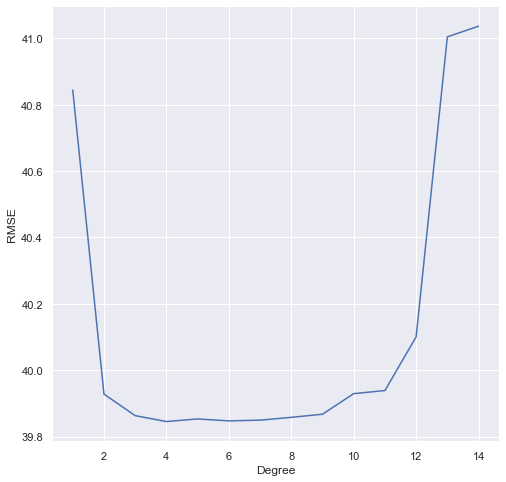

In [429]:
polynomial_regression(wage_df,wage_df['wage'])

In [108]:
degree = 5 
f = ' + '.join(['np.power(age,{})'.format(i) for i in np.arange(1,degree+1)])
X = pt.dmatrix(f,wage_df)
y = np.array(wage_df['wage'])

model1 = sm.OLS(y,X[:,0:2]).fit()
model2 = sm.OLS(y,X[:,0:3]).fit()
model3 = sm.OLS(y,X[:,0:4]).fit()
model4 = sm.OLS(y,X[:,0:5]).fit()
model5 = sm.OLS(y,X[:,0:6]).fit()

# Compare models with ANOVA
display(sm.stats.anova_lm(model1, model2, model3, model4, model5))

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2998.0,5.022216e+06,0.0,NaN,NaN,NaN
1,2997.0,4.793430e+06,1.0,228786.010128,143.593107,2.363850e-32
2,2996.0,4.777674e+06,1.0,15755.693664,9.888756,1.679202e-03
3,2995.0,4.771604e+06,1.0,6070.152124,3.809813,5.104620e-02
4,2994.0,4.770322e+06,1.0,1282.563017,0.804976,3.696820e-01


Comment:
- Cross validation chooses a 4th degree polynomial model. Anova selects the 3rd degree model which scores only marginally below optimal in cross validation. It would be interesting to see which performs best in test.

**(b) Fit a step function to predict wage using age, and perform crossvalidation to choose the optimal number of cuts. Make a plot of the fit obtained**

In [122]:
results = []

for s in np.arange(2,100):
    cuts = pd.cut(wage['age'],s)
    X = np.array(pd.get_dummies(cuts))
    y = np.array(wage['wage'])
    results += [[ols_cv(f,X,y,10),s]]
    
    
    


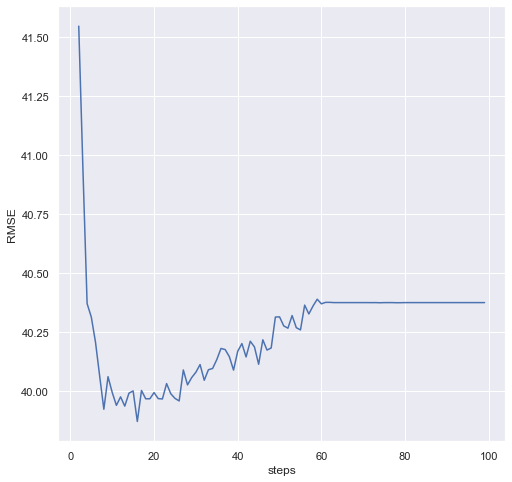

16.0

In [144]:
plt.figure(figsize=(8,8))
steps_df = pd.DataFrame({'steps':np.array(results)[:,1],'RMSE':np.array(results)[:,0]})
sns.lineplot(x='steps',y='RMSE',data=steps_df)
plt.show()

minsteps = steps_df[steps_df['RMSE']==steps_df['RMSE'].min()]
minsteps.iloc[0]['steps']

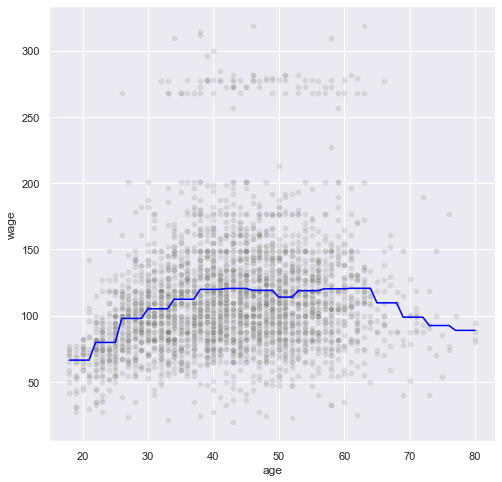

In [153]:
#BEST MODEL:
best_cuts = pd.cut(wage['age'],minsteps.iloc[0]['steps'])
X = np.array(pd.get_dummies(best_cuts))
y = np.array(wage['wage'])
best_model = sm.OLS(y,X).fit()
y_hat = best_model.predict(X)

#subpltos
fig,ax = plt.subplots(figsize= (8,8))
sns.scatterplot(x='age',y='wage',color='tab:gray',
                alpha=0.2,ax=ax,data=pd.concat([wage_df['age'], wage_df['wage']], axis=1))

sns.lineplot(x=wage['age'],y=y_hat,ax=ax,color='blue')
plt.show()

## 7. The Wage data set contains a number of other features not explored in this chapter, such as marital status (maritl), job class (jobclass), and others. Explore the relationships between some of these other predictors and wage, and use non-linear fitting techniques in order to fit flexible models to the data. Create plots of the results obtained, and write a summary of your findings.

In [173]:
url = 'https://raw.githubusercontent.com/JWarmenhoven/ISLR-python/master/Notebooks/Data/Wage.csv'
wage_df = pd.read_csv(url, error_bad_lines=False)
#wage_df.drop(wage_df['Unnamed: 0'],axis=1)
wage_df.head()

,Unnamed: 0,year,age,sex,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,231655,2006,18,1. Male,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,86582,2004,24,1. Male,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,161300,2003,45,1. Male,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,155159,2003,43,1. Male,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,11443,2005,50,1. Male,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


In [174]:
wage_df = wage_df.drop(['Unnamed: 0'],axis=1)

In [175]:
wage_df

,year,age,sex,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Male,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Male,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,1. Male,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,1. Male,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,1. Male,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154
...,...,...,...,...,...,...,...,...,...,...,...,...
2995,2008,44,1. Male,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,2. >=Very Good,1. Yes,5.041393,154.685293
2996,2007,30,1. Male,2. Married,1. White,2. HS Grad,2. Middle Atlantic,1. Industrial,2. >=Very Good,2. No,4.602060,99.689464
2997,2005,27,1. Male,2. Married,2. Black,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.193125,66.229408
2998,2005,27,1. Male,1. Never Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,2. >=Very Good,1. Yes,4.477121,87.981033


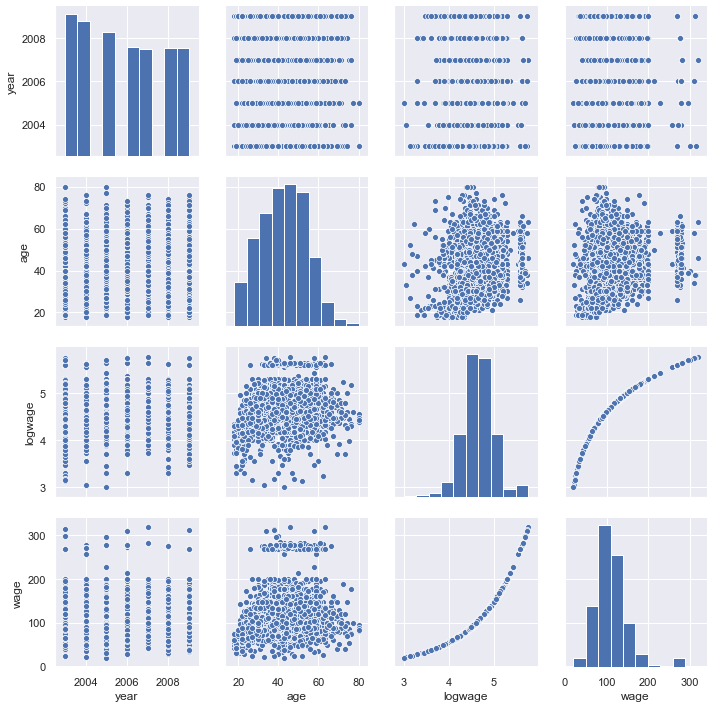

In [166]:
sns.pairplot(wage_df)

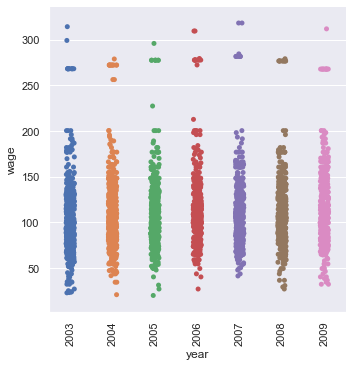

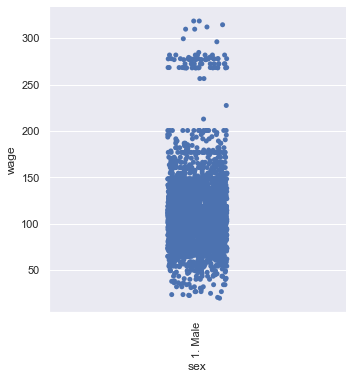

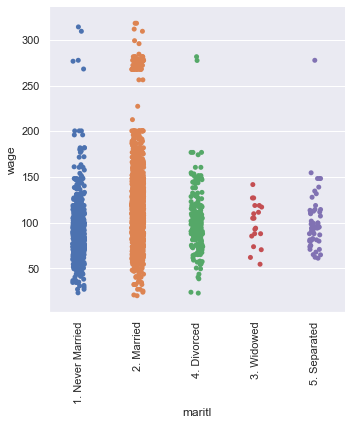

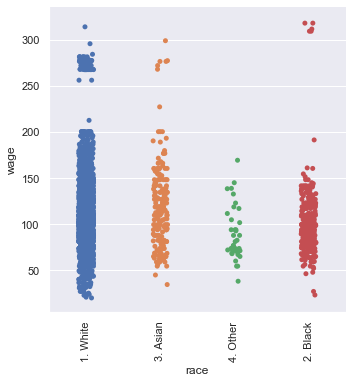

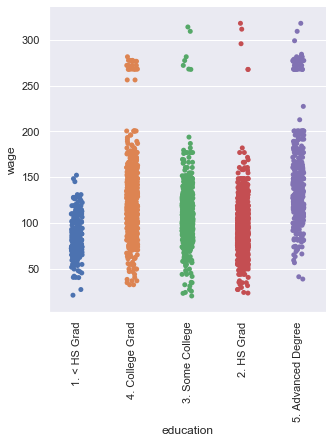

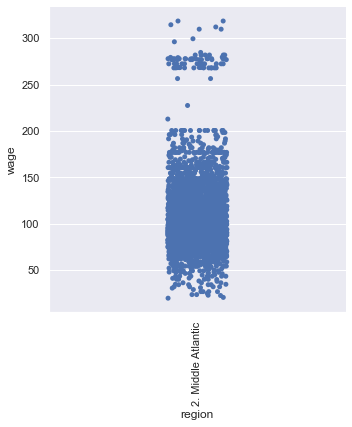

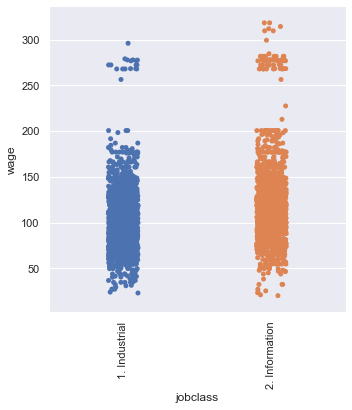

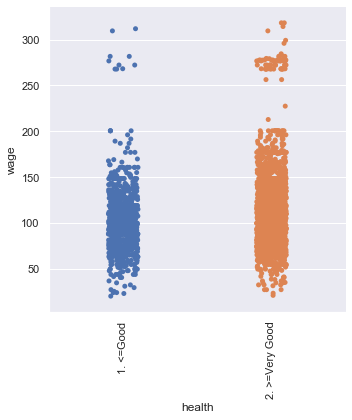

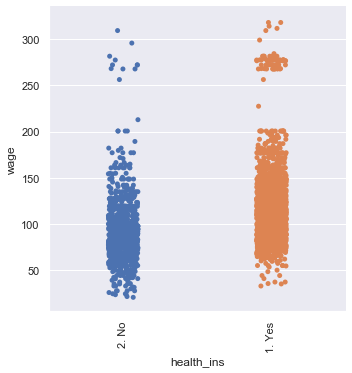

In [169]:
categoricals = wage_df.drop(['age','logwage','wage'],axis=1)
for c in categoricals.columns:
    sns.catplot(x=c,y='wage',data=wage_df)
    plt.xticks(rotation=90)

Notes:

- region and sex only has one value so should be ignored
- health and health_ins look quite similar so only one of those might be needed
- age we know from above that 4 degree polynomial models well
- education we know from lab is best modelled as linear
- log wage is just log of wage so we'll drop it

**So how to find the best model?**

We know that:

- age is nonlinear
- education is fairly linear
- year is linear
- logwage, and region can be ignored
- the rest are linear dummy variables

Approaches I can think of:

- come up with some rang of models with different features and degrees of freedom then compare
- find the best model for each predictor feature indivivudally (slow) then combine with a GAM
- create a big GAM with basis functions appropriate to what is known so far, then perform backward stepwise selection

Let's try to last one!

In [178]:
wage_df['education'] = wage_df['education'].map({'1. < HS Grad':1,
                                                '2. HS Grad':2,
                                                '3. Some College':3,
                                                '4. College Grad':4,
                                                '5. Advanced Degree':5})
wage_df.head()

,year,age,sex,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Male,1. Never Married,1. White,1,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Male,1. Never Married,1. White,4,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,1. Male,2. Married,1. White,3,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,1. Male,2. Married,3. Asian,4,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,1. Male,4. Divorced,1. White,2,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


**Approach 1 – Naive backward stepwise selection**

Min RMSE            : 33.95474812865035
Best predictor count: 16


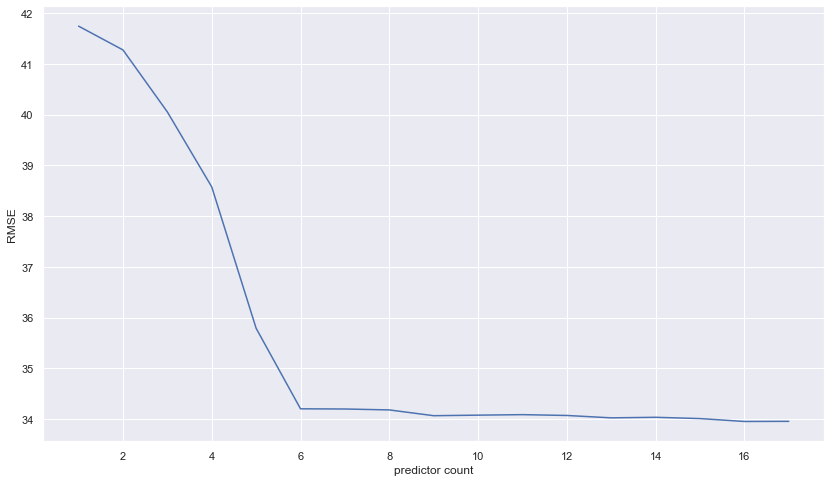

,predictor,selected
0,Intercept,True
1,C(race)[T.2. Black],True
2,C(race)[T.3. Asian],True
3,C(race)[T.4. Other],True
4,C(maritl)[T.2. Married],True
5,C(maritl)[T.3. Widowed],True
6,C(maritl)[T.4. Divorced],False
7,C(maritl)[T.5. Separated],True
8,C(jobclass)[T.2. Information],True
9,C(health)[T.2. >=Very Good],True


In [204]:
formula = 'year + education + cr(age,4) +  C(race) + C(maritl) +  C(jobclass) + C(health) + C(health_ins) '
X = pt.dmatrix(formula,wage_df)
y = np.array(wage_df['wage'])

estimator = LinearRegression(fit_intercept=False)
selector = RFECV(estimator,step=1,cv=10,scoring='neg_mean_squared_error').fit(X,y)

RMSEs_backward  = np.sqrt(np.abs(selector.grid_scores_))
predictor_count = np.arange(1, 1+len(RMSEs_backward))
print('Min RMSE            : {}'.format(min(RMSEs_backward)))
print('Best predictor count: {}'.format(np.sum(selector.support_)))

# Plot RMSE for each step
fig, ax = plt.subplots(figsize=(14, 8))
sns.lineplot(x='predictor count', y='RMSE', ax=ax, 
             data=pd.DataFrame({'RMSE': RMSEs_backward, 'predictor count': predictor_count}))
plt.show();

# Show selected features
display(HTML('<h4>Features selected</h4>'))
display(pd.DataFrame({'predictor': X.design_info.column_names,
                      'selected': selector.ranking_ == 1}))

- Backward stepwise selects a model with all features except 'Divorced', reporting an RMSE of 33.97. A marked improvement on the best RMSE achieved for univariate regression of age with 4 degree polynomial: 39.8.

- Note: sklearn's RFECV functions used here for backward stepwise doesn't allow us to set the random seed used for k-fold splits, which means that there will be variance when trying to reproduce above results. I've observed this effect by running the above mult times. This is bad science, we really need a method that is reproducible.

### Approach 2 – Selection of optimal DOF for age by cross valiation, then backward stepwise treating age spline features as single feature**

**Step 1**

Choose optimal degrees of freedom for age by holding all other predictors still whilst varying dof, then testing with cross validations.

In [207]:
def ols_cv(X,y,k):
    
    X_folds = np.array(np.array_split(X,k))
    y_folds = np.array(np.array_split(y,k))
    
    RMSEs = []
    for p in np.arange(k):
        X_test = X_folds[p]
        y_test = y_folds[p]
        X_train = np.delete(X_folds,p,axis=0).reshape(-1,X_folds.shape[-1])
        y_train = np.delete(y_folds,p,axis=0).reshape(-1,1)
        
        #fit model
        model = sm.OLS(y_train,X_train).fit()
        #predict
        y_hat = model.predict(X_test)
        RMSEs += [np.sqrt(metrics.mean_squared_error(y_test,y_hat))]
    
    return np.mean(MSEs)   
        

Min RMSE: 33.83243960258712
Min degree: 4.0


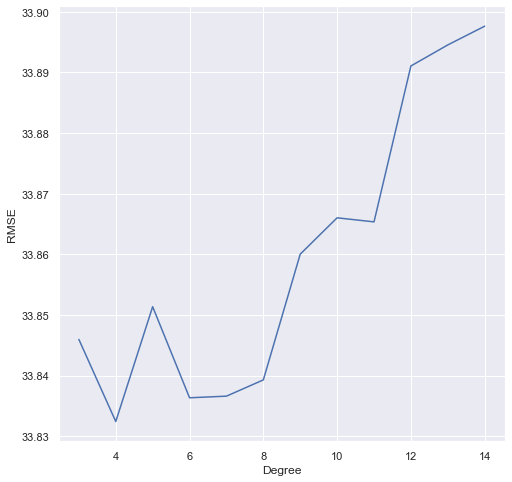

In [214]:
results = []
for d in np.arange(3,15):
    f = 'year + education + cr(age, df={}) + C(maritl) + C(race) + C(jobclass) + C(health) + C(health_ins)'.format(d)
    X = pt.dmatrix(f,wage_df)
    y = np.array(wage_df['wage'])
    results += [[ols_cv(X,y,10),d]]

df = pd.DataFrame({'RMSE': np.array(results)[:,0],
                  'Degree': np.array(results)[:,1]})

plt.figure(figsize=(8,8))
sns.lineplot(x='Degree',y='RMSE',data=df)

print("Min RMSE: {}".format(df[df['RMSE']==df['RMSE'].min()].iloc[0]['RMSE']))
print("Min degree: {}".format(df[df['RMSE']==df['RMSE'].min()].iloc[0]['Degree']))

**Step 2**

Estimate best subset of features in each subset of p predictors using backward stepwise selection.

In [269]:
def backward_stepwise(predictors, response, data, scorer = 'ssr', results=[]):
    """Perform backward stepwise variable selection as described in
    An Introductions to Statistical Learning (p.209)
    Returns pandas dataframe object  with results for each step"""
    
    p_all = predictors
    
    if not results:
        # Fit model with all features
        f     = '{} ~ {}'.format(response, '+'.join(p_all))
        model = smf.ols(formula=f, data=data).fit()
        # Begin backward stepwise recursion
        if scorer == 'ssr':
            return backward_stepwise(predictors, response, data, scorer, [(model.ssr, p_all)])
        if scorer == 'rsquared_adj':
            return backward_stepwise(predictors, response, data, scorer, [(model.rsquared_adj, p_all)])
        if scorer == 'bic':
            return backward_stepwise(predictors, response, data, scorer, [(model.bic, p_all)])
        if scorer == 'aic':
            return backward_stepwise(predictors, response, data, scorer, [(model.aic, p_all)])
    else:
        p_used = results[-1][1]
    
    if len(p_used)==1:
        print(p_used)
        scores = [r[0] for r in results]
        predictors = [r[1] for r in results]
        return pd.DataFrame({scorer:scores,'predictors':predictors})
        
    r = []
    for p in p_used:
        p_test = [i for i in p_used if i != p]
        f     = '{} ~ {}'.format(response, '+'.join(p_test))
        # Fit model
        model = smf.ols(formula=f, data=data).fit()
        r     += [(model, p_test)]
    
                      
    # Choose removal of predictor which yields best score
    if scorer == 'ssr':
        best_model = sorted(r, key=lambda tup: tup[0].ssr)[0]
        best_score = (best_model[0].ssr, best_model[1])
    elif scorer == 'rsquared_adj':
        best_model = sorted(r, key=lambda tup: tup[0].rsquared_adj)[-1]
        best_score = (best_model[0].rsquared_adj, best_model[1])        
    elif scorer == 'bic':
        best_model = sorted(r, key=lambda tup: tup[0].bic)[0]
        best_score = (best_model[0].bic, best_model[1]) 
    elif scorer == 'aic':
        best_model = sorted(r, key=lambda tup: tup[0].aic)[0]
        best_score = (best_model[0].aic, best_model[1]) 
        
    new_results = results + [best_score]
    
    return backward_stepwise(predictors,response,data,scorer, new_results)

 


In [270]:
response = 'wage'
predictors = ['year', 
              'education', 
              'cr(age, df=4)', 
              'C(maritl)',
              'C(race)',
              'C(jobclass)',
              'C(health)',
              'C(health_ins)']


backward_stepwise(predictors, response, wage_df, scorer='rsquared_adj')

['education']


,rsquared_adj,predictors
0,0.339702,"[year, education, cr(age, df=4), C(maritl), C(..."
1,0.338997,"[year, education, cr(age, df=4), C(maritl), C(..."
2,0.337713,"[year, education, cr(age, df=4), C(maritl), C(..."
3,0.334062,"[education, cr(age, df=4), C(maritl), C(health..."
4,0.329653,"[education, cr(age, df=4), C(maritl), C(health..."
5,0.315742,"[education, C(maritl), C(health_ins)]"
6,0.276739,"[education, C(maritl)]"
7,0.226104,[education]


In [408]:
def backward_stepwise_patsy(predictors, response, data, scorer='ssr', results=[]):
    """Perform backward stepwise variable selection as described in
    An Introductions to Statistical Learning (p.209)
    Returns pandas dataframe object  with results for each step"""
    # List predictors that havent's been used so far
    p_all = predictors

    # Check if we're starting out here
    if not results:
        # Fit model with all features
        f     = '{} ~ {}'.format(response, '+'.join(p_all))
        model = smf.ols(formula=f, data=data).fit()
        # Begin backward stepwise recursion
        if scorer == 'ssr':
            return backward_stepwise_patsy(predictors, response, data, scorer, [(model.ssr, p_all)])
        if scorer == 'rsquared_adj':
            return backward_stepwise_patsy(predictors, response, data, scorer, [(model.rsquared_adj, p_all)])
        if scorer == 'bic':
            return backward_stepwise_patsy(predictors, response, data, scorer, [(model.bic, p_all)])
        if scorer == 'aic':
            return backward_stepwise_patsy(predictors, response, data, scorer, [(model.aic, p_all)])
    else:
        p_used = results[-1][1]
    
    # Job done, exit recursion
    if len(p_used) == 1:
        scores = [r[0] for r in results]
        preds  = [r[1] for r in results]
        return pd.DataFrame({'scorer': scores, 'predictors': preds})    
    
    # Get rss score for each possible removed predictor
    r = []
    for p in p_used:
        p_test = [i for i in p_used if i != p]
        f     = '{} ~ {}'.format(response, '+'.join(p_test))
        # Fit model
        model = smf.ols(formula=f, data=data).fit()
        r     += [(model, p_test)]
    
    # Choose removal of predictor which yields best score
    if scorer == 'ssr':
        best_model = sorted(r, key=lambda tup: tup[0].ssr)[0]
        best_score = (best_model[0].ssr, best_model[1])
    elif scorer == 'rsquared_adj':
        best_model = sorted(r, key=lambda tup: tup[0].rsquared_adj)[-1]
        best_score = (best_model[0].rsquared_adj, best_model[1])        
    elif scorer == 'bic':
        best_model = sorted(r, key=lambda tup: tup[0].bic)[0]
        best_score = (best_model[0].bic, best_model[1]) 
    elif scorer == 'aic':
        best_model = sorted(r, key=lambda tup: tup[0].aic)[0]
        best_score = (best_model[0].aic, best_model[1]) 

    new_results = results + [best_score]
    # Recursive call to self
    return backward_stepwise_patsy(predictors, response, data, scorer, new_results)

def plot_backward(df,scorer):
       
    plt.figure(figsize=(8,8))
    sns.lineplot(x=df['predictors'].astype(str),y=df['scorer'],sort=False)
    plt.xticks(rotation=90)
    plt.show()
    
    if scorer=='rsquared_adj':
        display(df[df['scorer']==df['scorer'].max()])
        return df
    else:
        display(df[df['scorer']==df['scorer'].max()])
        return df



def ols_cv_patsy(formula, data, k):
    """Perform k-fold cross validation to return mean MSE score
    Expects formula as Patsy formula"""
    # Split dataset into k-folds
    # Note: np.array_split doesn't raise excpetion is folds are unequal in size
    y, X = pt.dmatrices(formula, wage_df)
    X_folds = np.array(np.array_split(X, k))
    y_folds = np.array(np.array_split(y, k))
    
    RMSEs = []
    for f in np.arange(len(X_folds)):
        # Create training and test sets
        X_test  = X_folds[f]
        y_test  = y_folds[f]
        X_train = np.delete(X_folds, f, 0).reshape(-1, X_folds.shape[-1])
        y_train = np.delete(y_folds, f, 0).reshape(-1, 1)
        
        # Fit model
        model = sm.OLS(y_train, X_train).fit()
        # Measure MSE
        y_hat = model.predict(X_test)
        RMSEs += [np.sqrt(metrics.mean_squared_error(y_test, y_hat))]
    return (np.mean(RMSEs), formula)

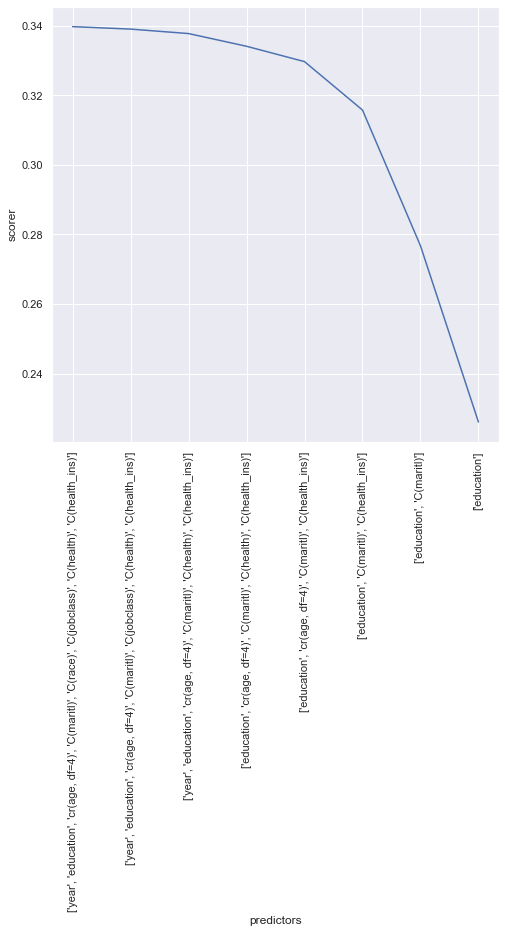

,scorer,predictors
0,0.339702,"[year, education, cr(age, df=4), C(maritl), C(..."


In [409]:
response = 'wage'
predictors = ['year', 
              'education', 
              'cr(age, df=4)', 
              'C(maritl)',
              'C(race)',
              'C(jobclass)',
              'C(health)',
              'C(health_ins)']


results = plot_backward(backward_stepwise_patsy(predictors, response, wage_df, scorer='rsquared_adj'),scorer='rsquared_adj')

In [410]:
predictor_subsets = list(results['predictors'])
predictor_subsets

[['year',
  'education',
  'cr(age, df=4)',
  'C(maritl)',
  'C(race)',
  'C(jobclass)',
  'C(health)',
  'C(health_ins)'],
 ['year',
  'education',
  'cr(age, df=4)',
  'C(maritl)',
  'C(jobclass)',
  'C(health)',
  'C(health_ins)'],
 ['year',
  'education',
  'cr(age, df=4)',
  'C(maritl)',
  'C(health)',
  'C(health_ins)'],
 ['education', 'cr(age, df=4)', 'C(maritl)', 'C(health)', 'C(health_ins)'],
 ['education', 'cr(age, df=4)', 'C(maritl)', 'C(health_ins)'],
 ['education', 'C(maritl)', 'C(health_ins)'],
 ['education', 'C(maritl)'],
 ['education']]

**Step 3**

Compare best models in each subset with 10-fold cross validation.

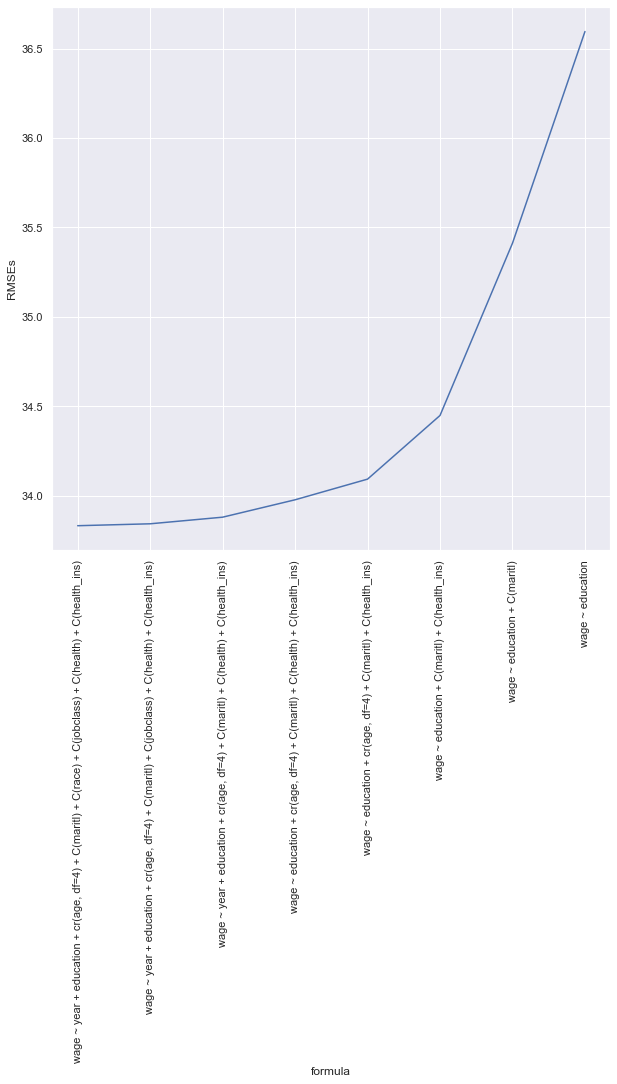

Min RMSE: 33.83243960258712
Model   : wage ~ year + education + cr(age, df=4) + C(maritl) + C(race) + C(jobclass) + C(health) + C(health_ins)


In [411]:
results = []
for i in predictor_subsets:
    formula = '{} ~ {}'.format(response,' + '.join(i))
    results += [ols_cv_patsy(formula,wage_df,10)]
    
fig, ax = plt.subplots(figsize=(10,10))
sns.lineplot(x='formula', y='RMSEs', ax=ax, sort=False,
             data=pd.DataFrame({'RMSEs': [i[0] for i in results], 'formula': [i[1] for i in results]}))
plt.xticks(rotation=90)
plt.show();

print('Min RMSE: {}'.format(min(results)[0]))
print('Model   : {}'.format(min(results)[1]))

We a arrive at a model that achives an RMSE CV score of 33.83, marginally lower than that achieved in approach 1 (33.97).

The selected model uses all features with 4 degrees of freedom for a cubic regression spline on age.

### 9. This question uses the variables dis (the weighted mean of distances to five Boston employment centers) and nox (nitrogen oxides concen- tration in parts per 10 million) from the Boston data. We will treat dis as the predictor and nox as the response.
**(a) Use the poly() function to fit a cubic polynomial regression to predict nox using dis. Report the regression output, and plot the resulting data and polynomial fits.**

In [335]:
from sklearn.datasets import load_boston
boston = load_boston()
boston_df = pd.DataFrame(data = boston.data,columns=boston.feature_names)
boston_df = boston_df[['DIS','NOX']]
boston_df

,DIS,NOX
0,4.0900,0.538
1,4.9671,0.469
2,4.9671,0.469
3,6.0622,0.458
4,6.0622,0.458
...,...,...
501,2.4786,0.573
502,2.2875,0.573
503,2.1675,0.573
504,2.3889,0.573


In [336]:
predictor =  'DIS'
response = 'NOX'

f = ' + '.join(['np.power(DIS,{})'.format(i) for i in np.arange(1,4)])
X = pt.dmatrix(f,data=boston_df)
y = np.array(boston_df[response])
model = sm.OLS(y,X).fit()
y_hat = model.predict(X)


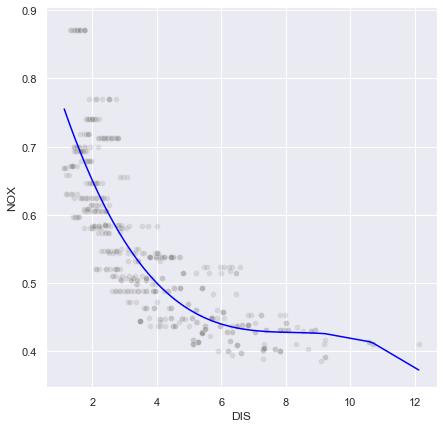

In [361]:
fig,ax = plt.subplots(figsize=(7,7))
# Plot datapoints
sns.scatterplot(x='DIS', y='NOX',
                color='tab:gray',
                alpha=0.2,
                ax=ax,
                data=boston_df)

# Plot estimated f(x)
sns.lineplot(x=boston_df['DIS'], y=y_hat, ax=ax, color='blue')
#sns.lineplot(x=boston_df['DIS'], y=y_hat*2, ax=ax, color='red')

**(b) Plot the polynomial fits for a range of different polynomial degrees (say, from 1 to 10), and report the associated residual sum of squares.**

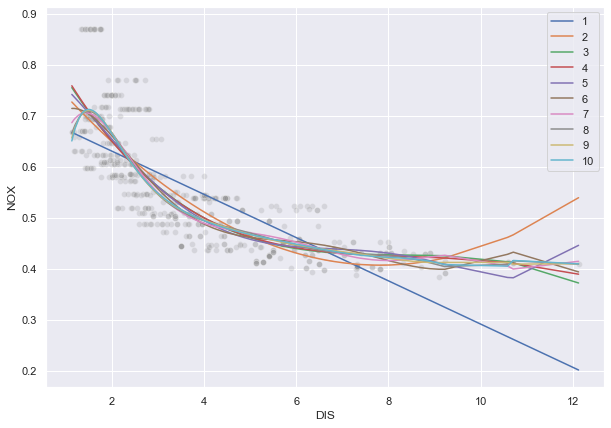

In [373]:
response = 'NOX'
y_hats = []
for i in np.arange(1,11):
    formula = ' + '.join(['np.power(DIS,{})'.format(d) for d in np.arange(1,i+1)])
    X = pt.dmatrix(formula,boston_df)
    y = np.array(boston_df[response])
    model = sm.OLS(y,X).fit()
    y_hats += [(i,model.predict(X))]
    #y_hats = model.predict(X)

fig,ax = plt.subplots(figsize=(10,7))
# Plot datapoints
sns.scatterplot(x='DIS', y='NOX',
                color='tab:gray',
                alpha=0.2,
                ax=ax,
                data=boston_df)


#sns.lineplot(x=boston_df['DIS'], y=y_hat*2, ax=ax, color='red')
for p in np.arange(len(y_hats)):
    sns.lineplot(x=boston_df['DIS'], y=y_hats[p][1], ax=ax)

ax.legend([y_hats[i][0] for i in np.arange(len(y_hats))])
plt.show()

**(c) Perform cross-validation or another approach to select the optimal degree for the polynomial, and explain your results.**

In [543]:
np.random.seed(523)
def Model_cv(formula,X,y,cv):
    
    #y, X = pt.dmatrices(f,boston_df)
    X_folds = np.array_split(X,cv)                       
    y_folds = np.array_split(y,cv)
    #print(X_folds)
    MSE = []
    for p in np.arange(len(X_folds)):
        X_test  = X_folds[p]
        y_test = y_folds[p]
        X_train = X.drop(X_test.index)
        y_train = y.drop(y_test.index)
        #fit
        model = smf.ols(formula,pd.concat([X_train,y_train],axis=1)).fit()
        y_hat = model.predict(X_test)
        MSE += [metrics.mean_squared_error(y_test,y_hat)]
    return np.mean(MSE)

' NOX ~ np.power(DIS,1)'

' NOX ~ np.power(DIS,1) + np.power(DIS,2)'

' NOX ~ np.power(DIS,1) + np.power(DIS,2) + np.power(DIS,3)'

' NOX ~ np.power(DIS,1) + np.power(DIS,2) + np.power(DIS,3) + np.power(DIS,4)'

' NOX ~ np.power(DIS,1) + np.power(DIS,2) + np.power(DIS,3) + np.power(DIS,4) + np.power(DIS,5)'

,MSE,Degree
2,0.004223,3


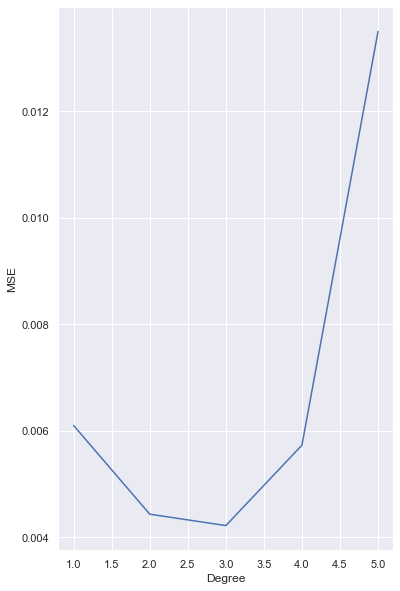

In [544]:
results = []
for p in np.arange(1,6):
    formula = ' {} ~ {}'.format('NOX', ' + '.join(['np.power(DIS,{})'.format(d) for d in np.arange(1,p+1)]))
    display(formula)
    results += [[Model_cv(formula,boston_df['DIS'],boston_df['NOX'],10),p]]

df = pd.DataFrame({'MSE': np.array(results)[:,0],'Degree':np.arange(1,6)})

plt.figure(figsize=(6,10))

sns.lineplot(x='Degree',y='MSE',data=df)
display(df[df['MSE']==df['MSE'].min()])

Text(0, 0.5, '10-fold CV MSE')

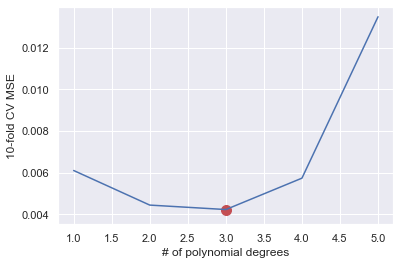

In [541]:
# alternative
from sklearn.model_selection import KFold,cross_val_score
lm     = LinearRegression()
cv_mse = np.zeros(5)
for i in range(1,6):
    poly        = PolynomialFeatures(i).fit_transform(boston_df['DIS'].values.reshape(-1,1))
    lm_fit      = lm.fit(poly, boston_df['NOX'])
    kf10        = KFold(n_splits=10, random_state=1)
    scores      = cross_val_score(lm_fit, poly, boston_df['NOX'], scoring="neg_mean_squared_error", cv=kf10)
    cv_mse[i-1] = np.mean(np.abs(scores))
    
plt.plot(range(1,6), cv_mse)
plt.scatter(cv_mse.argmin()+1, cv_mse.min(), s=100, c='r')
plt.xlabel('# of polynomial degrees')
plt.ylabel('10-fold CV MSE')

**(d) Use the bs() function to fit a regression spline to predict nox using dis. Report the output for the fit using four degrees of freedom. How did you choose the knots? Plot the resulting fit.**

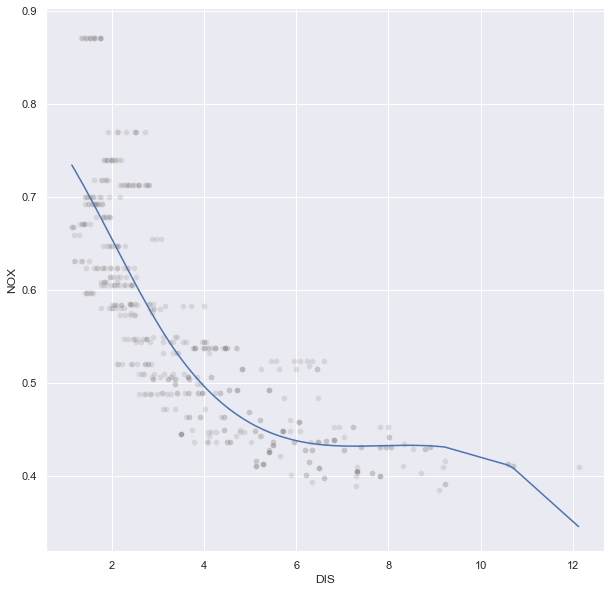

In [562]:
formula = 'NOX ~ bs(DIS,df=4)'
model = smf.ols(formula,boston_df).fit()
y_hat = model.predict(boston_df['DIS'])

fig, ax = plt.subplots(figsize=(10,10))

sns.scatterplot(x='DIS',y='NOX',color='tab:gray',
                alpha=0.2,
                ax=ax, data = boston_df)

sns.lineplot(x=boston_df['DIS'],y=y_hat)


**(e) Now fit a regression spline for a range of degrees of freedom, and plot the resulting fits and report the resulting RSS. Describe the results obtained.**

RSS 0-Degree: 1.9341067071790705
RSS 1-Degree: 1.922774992811925
RSS 2-Degree: 1.8401728014885232
RSS 3-Degree: 1.8339659031602094
RSS 4-Degree: 1.8298844459232841
RSS 5-Degree: 1.8169950567252338
RSS 6-Degree: 1.8256525103870564
RSS 7-Degree: 1.792534889556134
RSS 8-Degree: 1.7969918217314276
RSS 9-Degree: 1.7889991452888843
RSS 10-Degree: 1.7823504287434366
RSS 11-Degree: 1.7818380568631231


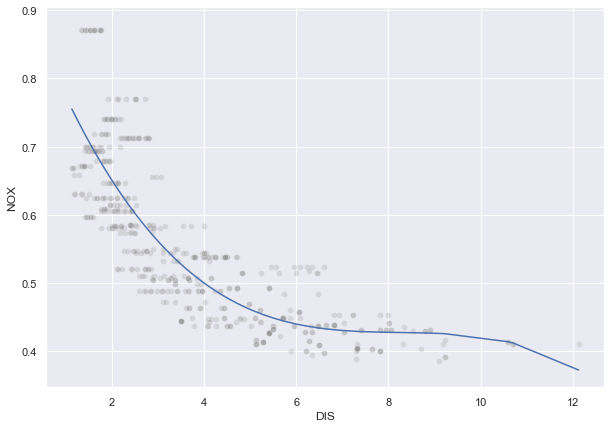

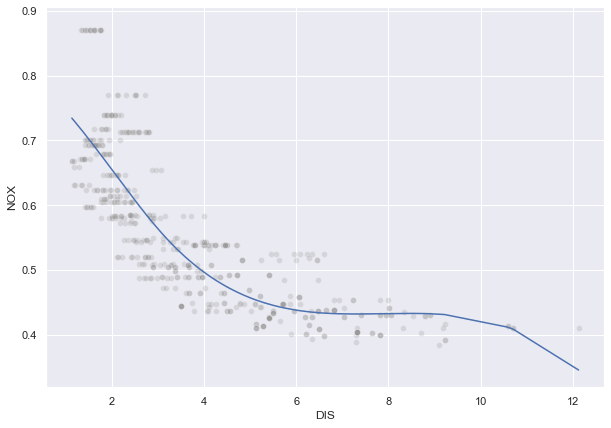

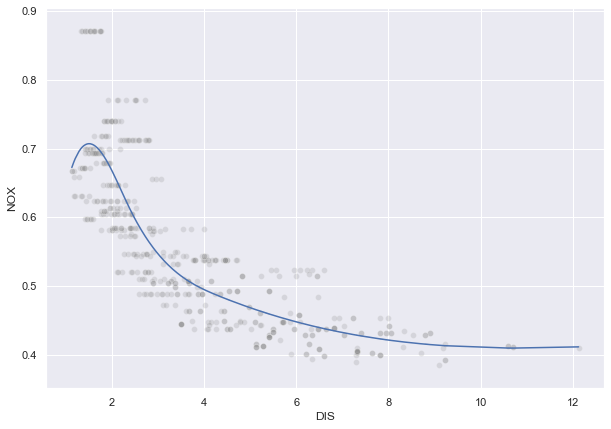

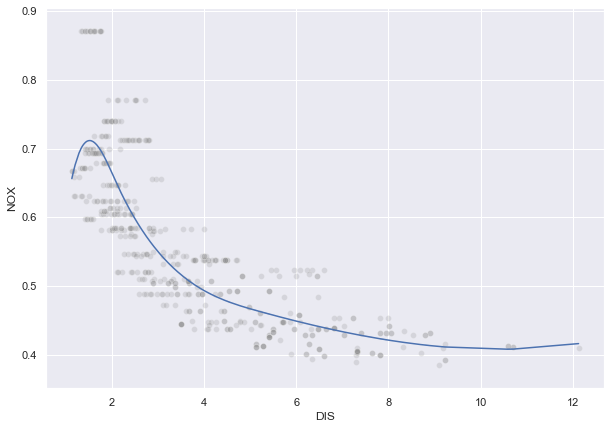

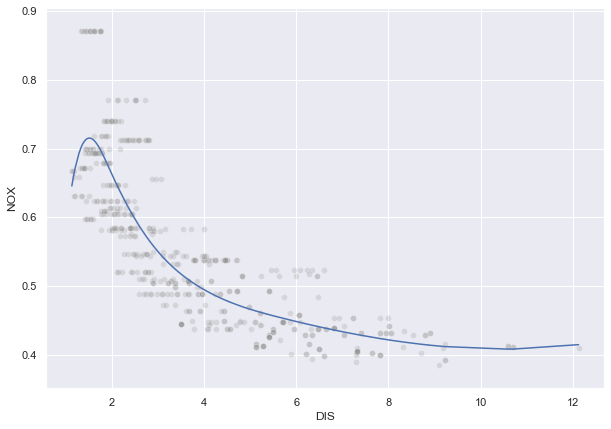

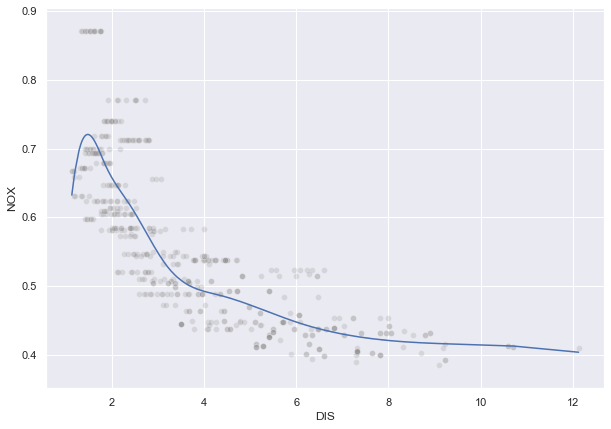

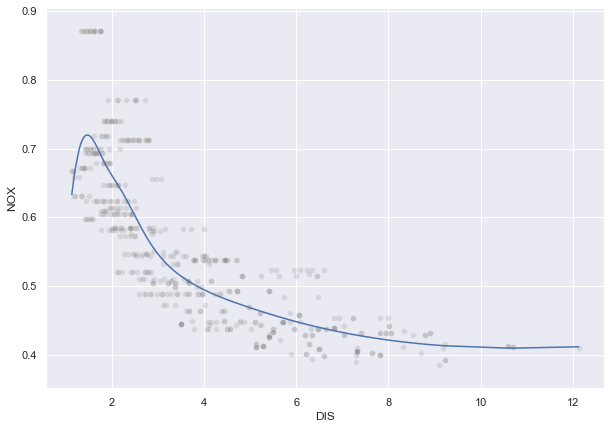

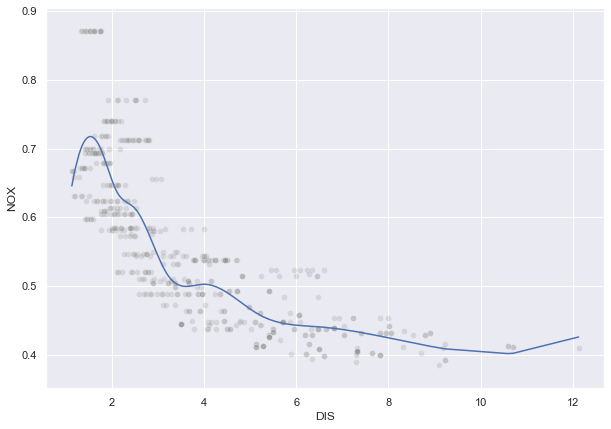

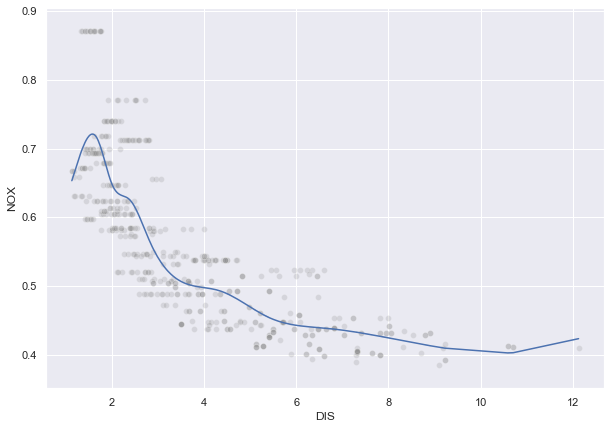

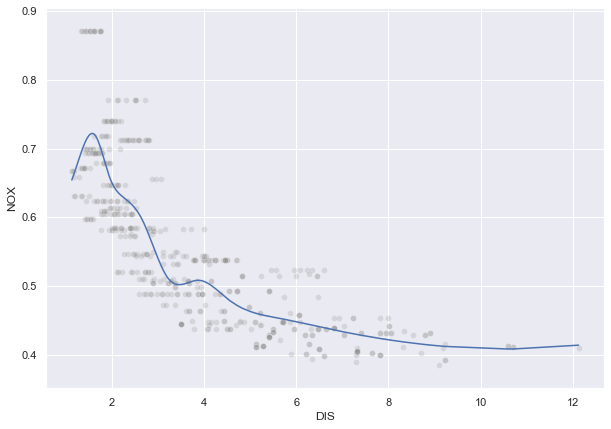

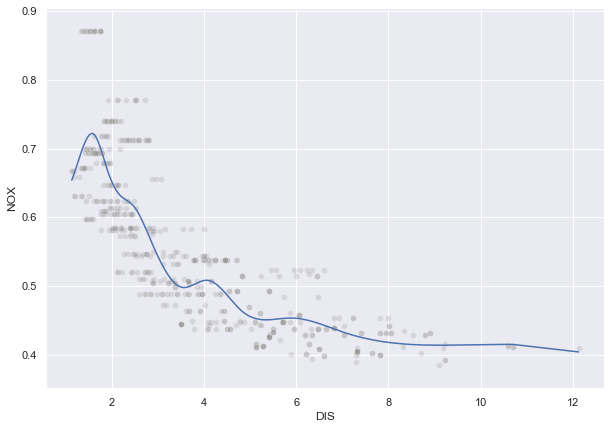

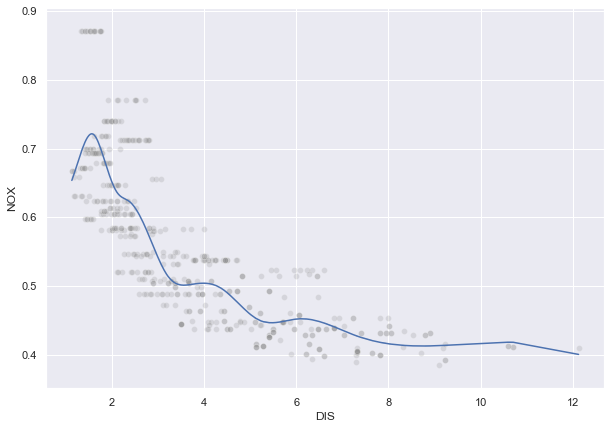

In [575]:
results = []
for p in np.arange(3,15):
    formula = 'NOX ~ bs(DIS,df={})'.format(p)
    model = smf.ols(formula,boston_df).fit()
    y_hat = model.predict(boston_df['DIS'])
    results += [[model.ssr,y_hat]]
    

#fig = plt.figure(figsize=(10,7))
# Plot datapoints



#sns.lineplot(x=boston_df['DIS'], y=y_hat*2, ax=ax, color='red')
for p in np.arange(len(results)):
    plt.figure(figsize=(10,7))
    sns.scatterplot(x='DIS', y='NOX',
                color='tab:gray',
                alpha=0.2,
                data=boston_df)
    sns.lineplot(x=boston_df['DIS'], y=results[p][1])
    print("RSS {}-Degree: {}".format(p,results[p][0]))
    



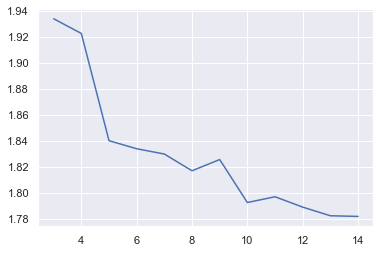

In [590]:
df2 = pd.DataFrame({'Degree': np.arange(3,15),'RSS':np.array(results)[:,0]})
df2

plt.plot(df2['Degree'],df2['RSS'])

Text(0, 0.5, 'RSS')

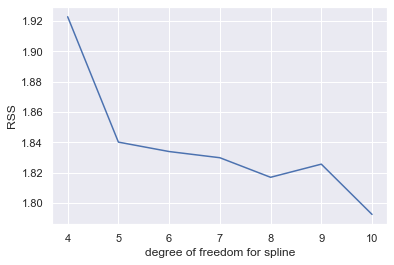

In [578]:
rss = np.zeros(7)
for i in range(4,11):
    sp       = dmatrix("bs(boston_df.DIS, df=i, include_intercept=False)", {"boston_df.dis": boston_df.DIS}, return_type='dataframe')
    fit      = sm.OLS(boston_df['NOX'], sp).fit()
    rss[i-4] = sum(fit.resid**2)

plt.plot(range(4,11), rss)
plt.xlabel('degree of freedom for spline')
plt.ylabel('RSS')

**(f) Perform cross-validation or another approach in order to select the best degrees of freedom for a regression spline on this data. Describe your results.**

In [593]:
models=[]
for p in range(4,11):
    f = 'NOX ~ bs(DIS,df={}) '.format(p)
    models += [smf.ols(f,boston_df).fit()]
    

# Compare models with ANOVA
display(sm.stats.anova_lm(models[0], models[1], models[2], models[3], models[4],models[5],models[6]))

    

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,501.0,1.922775,0.0,NaN,NaN,NaN
1,500.0,1.840173,1.0,0.082602,22.810203,0.000002
2,499.0,1.833966,1.0,0.006207,1.714006,0.191069
3,498.0,1.829884,1.0,0.004081,1.127075,0.288915
4,497.0,1.816995,1.0,0.012889,3.559344,0.059794
5,496.0,1.825653,1.0,-0.008657,-2.390715,1.000000
6,495.0,1.792535,1.0,0.033118,9.145274,0.002623


ANOVA chooses a model with 8 degrees of freedom

## 11. In Section 7.7, it was mentioned that GAMs are generally fit using a backfitting approach. The idea behind backfitting is actually quite simple. We will now explore backfitting in the context of multiple linear regression.

Suppose that we would like to perform multiple linear regression, but we do not have software to do so. Instead, we only have software to perform simple linear regression. Therefore, we take the following iterative approach: we repeatedly hold all but one coefficient estimate fixed at its current value, and update only that coefficient estimate using a simple linear regression. The process is continued until convergence that is, until the coefficient estimates stop changing.

We now try this out on a toy example

**(a) Generate a response Y and two predictors X1 and X2, with n = 100.**

In [606]:
np.random.seed(1)
x1  = np.random.normal(0, 1, 100)
x2  = np.random.normal(0, 1, 100)
eps = 0.1 * np.random.normal(0, 1, 100)

X = np.asarray([np.ones(100), x1, x2]).T
y = 0.2 + 2*x1 + 5*x2 + eps

**(c) Keeping β1 fixed, fit the model**

$y−β_1X_1=β_0+β_2X_2+ε$

Ordinary least squares regression is defined by the matrix operation:

$β̂ =(X^TX)^{−1}X^Ty$

In [607]:
beta1 = 20
ya = y - (beta1*x1)
Xa = np.asarray([np.ones(100), x2]).T

beta_hat = (np.linalg.inv(Xa.T @ Xa) @ Xa.T) @ ya
display(beta_hat)

array([-0.65602756,  3.47192688])

**(d) Keeping β2 fixed, fit the model**

$y−β_2X_2=β_0+β_1X_1+ε$

In [608]:
beta2 = beta_hat[1]

ya2 = y - (beta2*x2)
Xa2 = np.array([np.ones(100),x1]).T

beta_hat2 = (np.linalg.inv(Xa2.T @ Xa2) @ Xa2.T) @ ya2
display(beta_hat2)

array([0.42587836, 2.14171377])

**(e) Write a for loop to repeat (c) and (d) 1,000 times. Report the estimates of βˆ0, βˆ1, and βˆ2 at each iteration of the for loop. Create a plot in which each of these values is displayed, with βˆ0, βˆ1, and βˆ2 each shown in a different color**

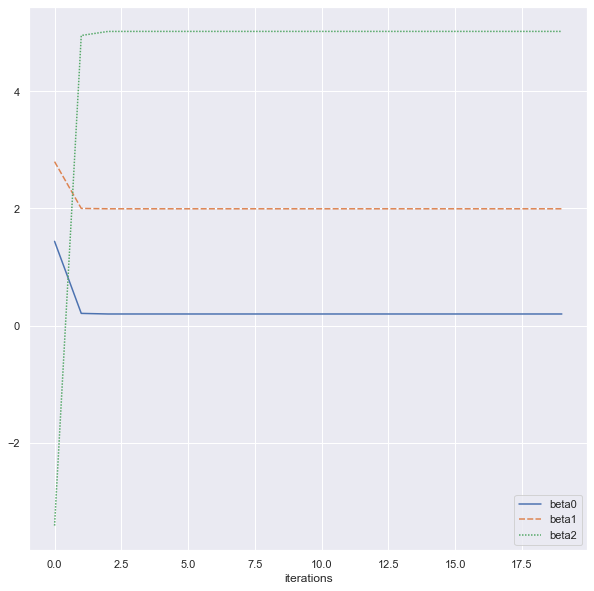

In [611]:
beta1 = 100

results= []
for i in range(20):
    # Keeping beta1 fixed, fit the model to estimate beta2
    ya = y - (beta1*x1)
    Xa = np.asarray([np.ones(100), x2]).T
    
    beta_hat = (np.linalg.inv((Xa.T @ Xa)) @ Xa.T) @ ya 
    beta2 = beta_hat[1]
    
    # Keeping beta2 fixed, fit the model beta1
    ya = y - (beta2*x2)
    Xa = np.asarray([np.ones(100), x1]).T
    
    beta_hat = (np.linalg.inv((Xa.T @ Xa)) @ Xa.T) @ ya
    beta1 = beta_hat[1]
    beta0 = beta_hat[0]
    results += [[beta0, beta1, beta2]]
    
fig = plt.figure(figsize=(10, 10))
ax = sns.lineplot(data=pd.DataFrame(np.asarray(results), columns=['beta0','beta1','beta2']))
ax.axhline(y=beta_mult[0], color='r', linestyle='dashed')
ax.axhline(y=-3, color='r', linestyle='dashed');
plt.xlabel('iterations');   

**(f) Compare your answer in (e) to the results of simply performing multiple linear regression to predict Y using X1 and X2. Use the abline() function to overlay those multiple linear regression coefficient estimates on the plot obtained in (e).**

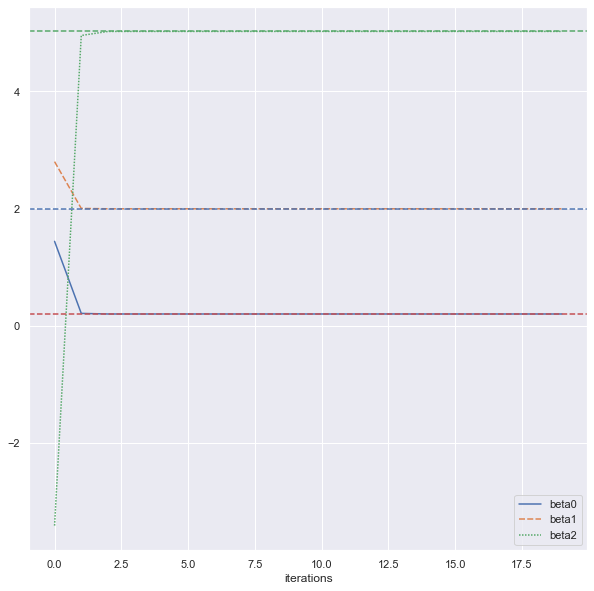

In [614]:
beta_mult = (np.linalg.inv((X.T @ X)) @ X.T) @ y
beta_mult

fig = plt.figure(figsize=(10, 10))
ax = sns.lineplot(data=pd.DataFrame(np.asarray(results), columns=['beta0','beta1','beta2']))
ax.axhline(y=beta_mult[0], color='r', linestyle='dashed')
ax.axhline(y=beta_mult[1], color='b', linestyle='dashed');
ax.axhline(y=beta_mult[2], color='g', linestyle='dashed');
plt.xlabel('iterations');   

**(g) On this data set, how many backfitting iterations were required in order to obtain a “good” approximation to the multiple re- gression coefficient estimates?**

Only TWO !!

### 12. This problem is a continuation of the previous exercise. In a toy example with p = 100, show that one can approximate the multiple linear regression coefficient estimates by repeatedly performing simple linear regression in a backfitting procedure. How many backfitting iterations are required in order to obtain a “good” approximation to the multiple regression coefficient estimates? Create a plot to justify your answer.

In [656]:
def gen_data(n, p):
    """Generate simulated data from normal distribution where:
    - n is number of observations
    - p is number of predictors
    
    Returns
    X, design matrix of predictors with bias variable
    y, response variable from linear model
    beta_true, the true coefficients of the linear model used to derive y from X
    beta_rand, a random vector of shape beta_true, useful as starting point for iterative estimatation
    """
    np.random.seed(1)
    # Generate 100 random observations for 100 predictors
    predictors = np.random.normal(0, 1, (n, p))
    # Add bias variable
    X = np.insert(predictors, 0, 1, axis=1)
    # Generate random beta coefficients
    beta_true = np.random.randint(0, 10, size=X.shape[1]).astype(np.float64)
    # Derive true y
    eps = 0.1* np.random.normal(0, 1, n)
    y = beta_true @ X.T + eps
    
    # Initalize beta at some random values
    beta_rand = list(np.random.randint(0, 10, size=X.shape[1]).astype(np.float64))
    
    return X, y, beta_true, beta_rand


def backfit(X, y, iterations:int, beta_ests:list):
    """Perform backfitting algorithm to recursively estimate
    beta parameters one at a time"""
    # Exit recursion
    if len(beta_ests) == iterations:
        return np.asarray(beta_ests)
    
    # Start recursion or iterate 
    beta_prev = copy.deepcopy(beta_ests[-1])
    beta_new  = np.zeros(len(beta_prev))
    # Perform one backfitting iteration to generate new set of estimates for all beta
    for j in  np.arange(1, X.shape[1]):
        # - Exclude predictors for which params are not being estimated in this pass (except intercept)
        # - Isolate predictors for which param is to be estimated in this pass
        # - Perform Ordinary Least Squares regression
        y_b = y - (np.delete(beta_prev[1:], j-1) @ np.delete(X[:, 1:], j-1, axis=1).T)
        X_b = X[:, [0,j]]
        beta_est = (np.linalg.inv((X_b.T @ X_b)) @ X_b.T) @ y_b
        # Save estimates, but include intercept estimate on first pass only
        if j == 1:
            beta_new[0] = beta_est[0]
            beta_new[1] = beta_est[1]
        else:
            beta_new[j] = beta_est[1]
        
    
    # Recur
    return backfit(X, y, iterations, beta_ests+[beta_new])


def backfit_plot(n, p, iterations):
    """Plot coefficient estimates for each iteration of backfitting for simulated data:
    - n is number of observations
    - p is number of predictors
    - iterations is number of backfitting iterations
    """
    # Gen simulated data
    X, y, beta_true, beta_rand = gen_data(n, p)
    
    beta_ests = backfit(X, y, iterations, [beta_rand])
    cols = ['x{}'.format(i) for i in range(p+1)]
    
    fig = plt.figure(figsize=(10, 10))
    for i in range(p+1):
        # Plot estimated coefficient
        sns.lineplot(data=beta_ests[:, i]);
        # Plot true coefficient
        plt.axhline(y=beta_true[i], linestyle='--')
    plt.xlabel('iterations')
    plt.ylabel('coefficients (β)')
    plt.show();
    #return beta_ests



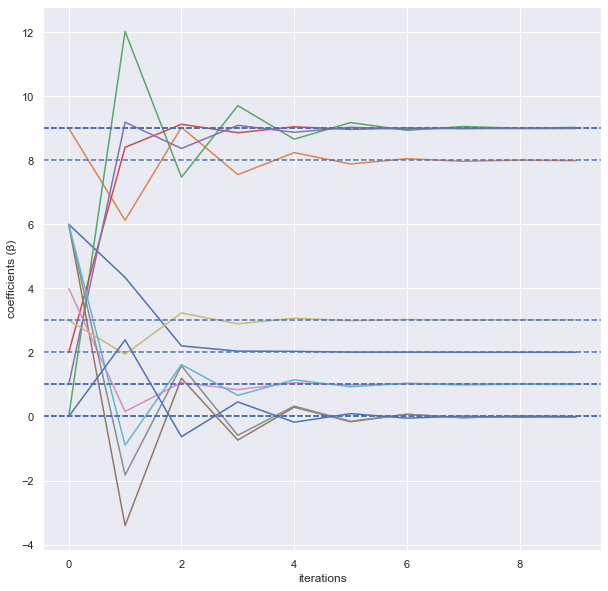

In [659]:
backfit_plot(n=100, p=10, iterations=10);

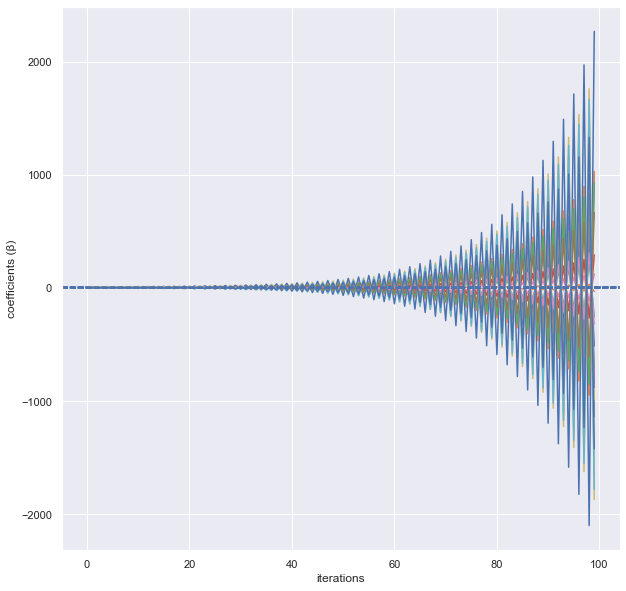

In [660]:
backfit_plot(n=100, p=20, iterations=100);

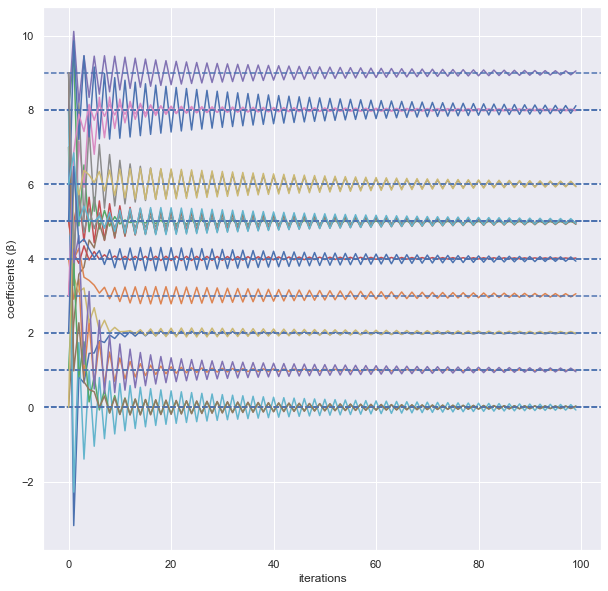

In [661]:
backfit_plot(n=110, p=20, iterations=100);

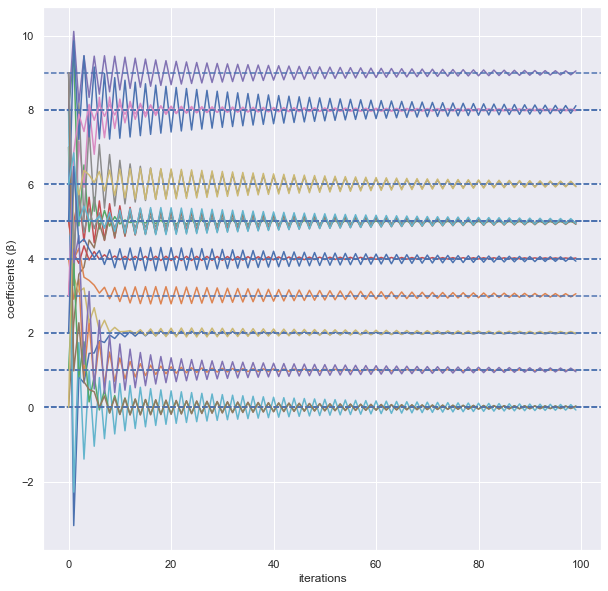

In [666]:
backfit_plot(n=110, p=20, iterations=100);

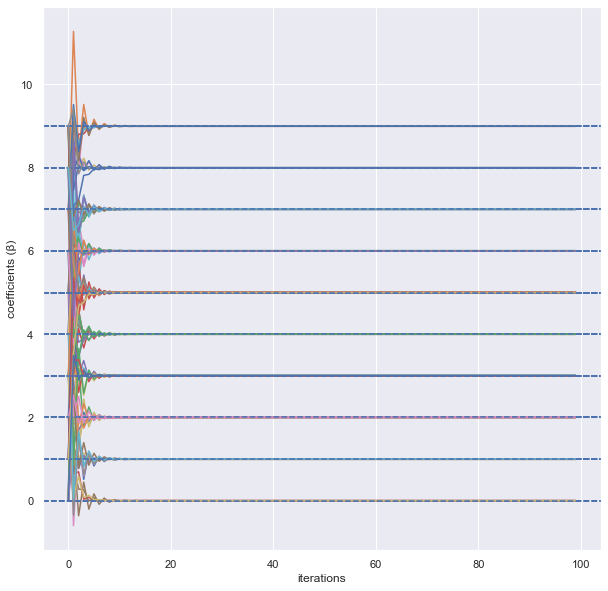

In [667]:
backfit_plot(n=1000, p=100, iterations=100);

**Comment:**

- Above I've plotted the coefficient estimates at each iteration from backfitting with data simulated from linear models with various numbers of predictors and observations. On each plot horizontal dashed lines show the true coefficient values.
- We can see that in some cases the backfitting estimates converge to the true value, and in some cases estimates are divergent.

- Convergence is dependant on the number of predictors p AND the number of observation n. Convergence is not observed when n < p. The factor by which n must be greater than p in order for convergence to occur doesn't seem to be constant, seems to be in the range 1.2p-10p

- Once the threshold of convergence is achieved, further increasing the ratio n:p serves to reduce the number of iterations required for a given level of convergence.